<a href="https://colab.research.google.com/github/SergeySmalkov/MarketMakingOptimizer/blob/main/MarketMakingOptimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

After rescaling MAD: 0.09999999999321464
After rescaling STD: 13.301012642909873


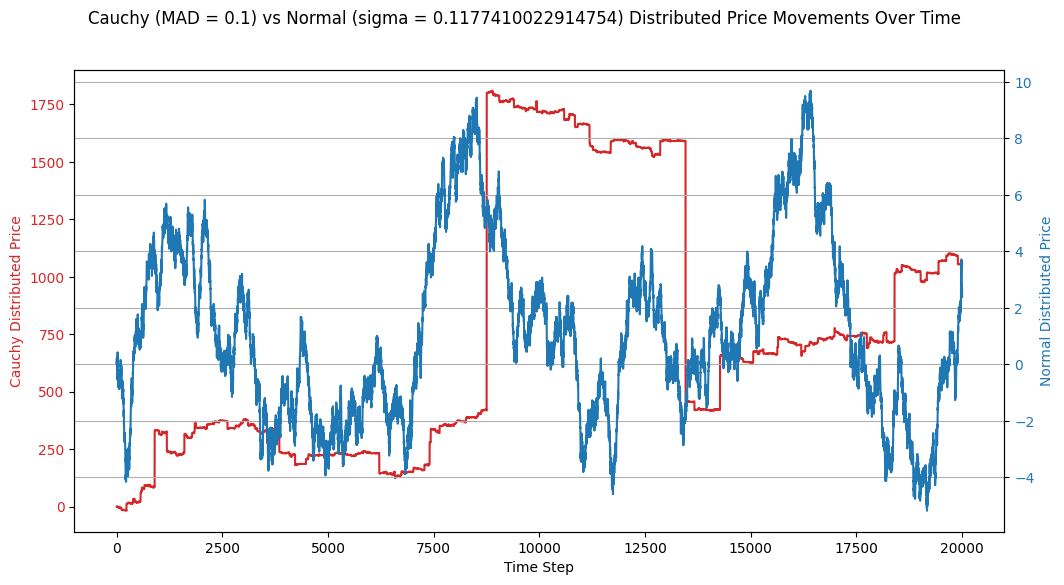

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

# Set the parameters
desired_mad = 0.1
sigma = desired_mad / 0.8493218  # Corresponding sigma for normal distribution
num_ticks = 20000

# Generate standard Cauchy distributed sequence of price changes
changes_cauchy = np.random.standard_cauchy(num_ticks)

# Compute the MAD of the generated sequence
cauchy_mad = median_abs_deviation(changes_cauchy, scale='normal')

# Add a small constant to avoid division by zero
epsilon = 1e-10

# Rescale the sequence so its MAD matches the desired MAD
changes_cauchy *= desired_mad / (cauchy_mad + epsilon)

print('After rescaling MAD:', median_abs_deviation(changes_cauchy, scale='normal'))
print('After rescaling STD:', changes_cauchy.std())


# Make sure the MAD of the rescaled sequence is close to the desired MAD
assert np.isclose(median_abs_deviation(changes_cauchy, scale='normal'), desired_mad, atol=1e-5)

# Generate Normal distributed sequences of price changes
changes_normal = np.random.normal(scale=sigma, size=num_ticks)

# Generate the price sequences by taking the cumulative sum of the changes
sequence_cauchy = np.cumsum(changes_cauchy)
sequence_normal = np.cumsum(changes_normal)

# Generate a sequence of time steps
time_steps = np.arange(num_ticks)

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the Cauchy-distributed sequence on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Cauchy Distributed Price', color=color)
ax1.plot(time_steps, sequence_cauchy, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create the secondary y-axis and plot the normal-distributed sequence on it
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Normal Distributed Price', color=color)
ax2.plot(time_steps, sequence_normal, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
fig.suptitle(f'Cauchy (MAD = {desired_mad}) vs Normal (sigma = {sigma}) Distributed Price Movements Over Time')
plt.grid(True)
plt.show()


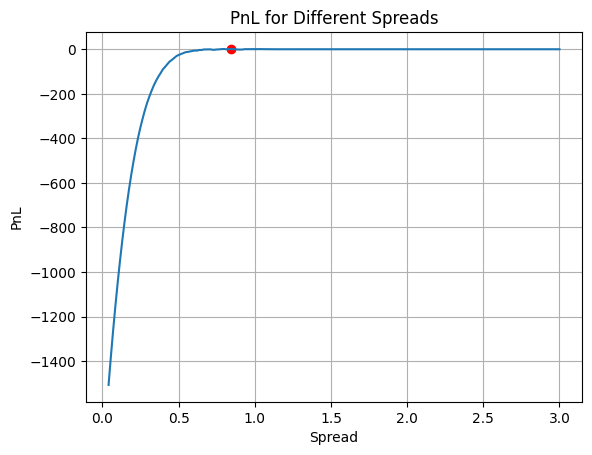

In [2]:
from numba import jit
plt.close('all')
# Define parameters
# sigma ~ gamma / 0.8493218
gamma = 0.1
sigma = gamma / 0.8493218

min_half_spread = 0.02
max_half_spread = 1.5

spreads = np.linspace(min_half_spread * 2 , max_half_spread * 2, 200)  # range of spreads to be tested
commission = 0.0001
num_sequences = 100
num_ticks = 20000


# Generate Cauchy distributed sequences of price changes
# changes = np.random.standard_cauchy((num_sequences, num_ticks)) * gamma
changes = np.random.normal(scale=sigma, size=(num_sequences, num_ticks))

# Generate the price sequences by taking the cumulative sum of the changes
sequences = np.cumsum(changes, axis=1)


@jit(nopython=True)
def simulate_strategy(sequence, spread):
    pnl = 0.0
    position = 0
    ask = bid = sequence[0]

    for i in range(1, len(sequence)):
        mid_price = sequence[i]
        ask = sequence[i-1] + spread / 2.0
        bid = sequence[i-1] - spread / 2.0

        if position == -1:  # we have a short position
            if mid_price <= bid:  # our bid is hit
                pnl -= 2 * (bid + commission)  # we buy to 2
                position = 1
            continue
        elif position == 1:  # we have a long position
            if mid_price >= ask:  # our ask is hit
                pnl += 2 * (ask - commission)  # we sell 2
                position = -1
            continue
        elif position == 0:
            if mid_price >= ask:  # our ask is hit
                pnl += (ask - commission)
                position = -1
            elif mid_price <= bid:
                pnl -= (bid + commission)
                position = 1
            continue


    # Close any open position at the end of the sequence
    if position != 0:
        pnl += position * sequence[-1] - commission
        position = 0

    return pnl

# Iterate over each spread and each sequence, accumulating PnL for each spread
pnls = np.zeros_like(spreads)
for i, spread in enumerate(spreads):
    for seq in sequences:
        pnls[i] += simulate_strategy(seq, spread)

pnls = pnls / num_sequences

# Plot the results
plt.plot(spreads, pnls)
plt.scatter(spreads[np.argmax(pnls)], pnls.max(), color='r')  # Mark the max PnL
plt.title("PnL for Different Spreads")
plt.xlabel("Spread")
plt.ylabel("PnL")
plt.grid(True)
plt.show()

<ipython-input-3-03c74f8a3886>:52: UserWarning: The label '_child4' of <matplotlib.lines.Line2D object at 0x7cfddc3e2a70> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles=legend_elements, loc='upper right')
<ipython-input-3-03c74f8a3886>:52: UserWarning: The label '_child6' of <matplotlib.lines.Line2D object at 0x7cfd939a9990> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles=legend_elements, loc='upper right')
<ipython-input-3-03c74f8a3886>:52: UserWarning: The label '_child8' of <matplotlib.lines.Line2D object at 0x7cfd9397d150> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles=legend_elements, loc='upper right')


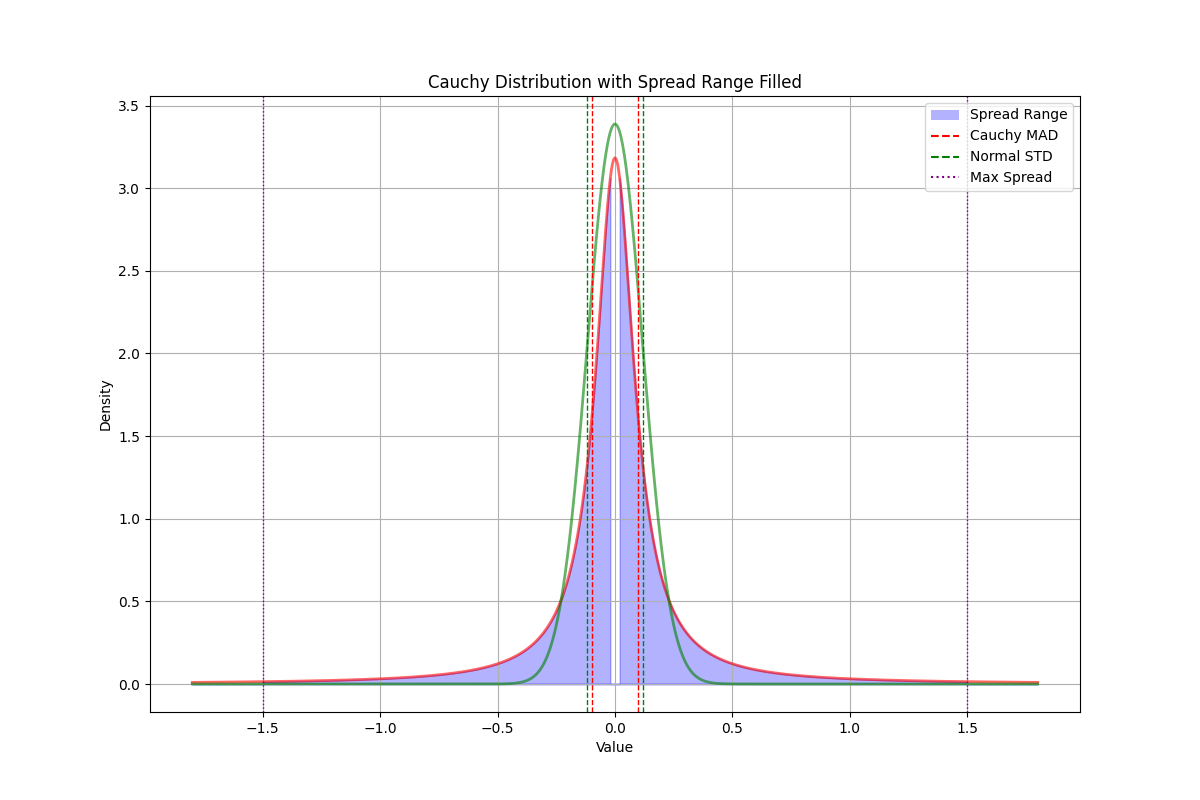

In [3]:
from scipy.stats import cauchy
from google.colab import output
output.enable_custom_widget_manager()
from mpl_interactions import ioff, panhandler, zoom_factory
%matplotlib widget
from scipy.stats import norm
from matplotlib.patches import Patch
import matplotlib.lines as mlines
plt.close('all')
# Calculate the standard deviation for the normal distribution
sigma = gamma / 0.8493218


x = np.linspace(-max_half_spread*1.2, max_half_spread*1.2, 1000000)

# Generate Normal distributed sequences
pdf_normal = norm.pdf(x, scale=sigma)
# Generate a more fine-grained set of x values
pdf = cauchy.pdf(x, scale=gamma)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(x, pdf, 'r-', lw=2, alpha=0.6, label='Cauchy pdf')
ax.plot(x, pdf_normal, 'g-', lw=2, alpha=0.6, label='Normal pdf')


spread_area = np.where((x >= min_half_spread) & (x <= max_half_spread), pdf, 0)
ax.fill_between(x, 0, spread_area, color='blue', alpha=0.3)

spread_area = np.where((-x >= min_half_spread) & (-x <= max_half_spread), pdf, 0)
ax.fill_between(x, 0, spread_area, color='blue', alpha=0.3)

cauchy_line = ax.axvline(gamma, color='r', linestyle='dashed', linewidth=1)
ax.axvline(-gamma, color='r', linestyle='dashed', linewidth=1)
normal_line = ax.axvline(sigma, color='g', linestyle='dashed', linewidth=1)
ax.axvline(-sigma, color='g', linestyle='dashed', linewidth=1)

max_spread_line = ax.axvline(max_half_spread, color='purple', linestyle='dotted', linewidth=1)
ax.axvline(-max_half_spread, color='purple', linestyle='dotted', linewidth=1)


plt.title('Cauchy Distribution with Spread Range Filled')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)

# Add legends for both lines and patches
legend_elements = [Patch(facecolor='blue', alpha=0.3, label='Spread Range'),
                   cauchy_line, normal_line, max_spread_line,
                   mlines.Line2D([], [], color='r', linestyle='dashed', label='Cauchy MAD'),
                   mlines.Line2D([], [], color='g', linestyle='dashed', label='Normal STD'),
                   mlines.Line2D([], [], color='purple', linestyle='dotted', label='Max Spread')]
ax.legend(handles=legend_elements, loc='upper right')
plt.show()

